# **Índice**

### **0 - Carregamento das bibliotecas e da base de dados**

### **1 - Análise das variáveis**
1.1 - Análise geral

1.2 - Análise das variáveis categóricas não binárias

### **2 - Pré-processamento**
2.1 - Variáveis binárias e categóricas

2.2 - Variáveis W2V

2.3 - Pré-processamento da base de teste

### **3 - Modelos**
3.1 - Modelo 1 - Random Forest

3.2 - Modelo 2 - MLP

3.3 - Modelo 3 - XGBoost

3.4 - Ensembles

### **4 - Avaliação e escolha do modelo**
4.1 - Acurácia

4.2 - Matriz de confusão

4.3 - Curva ROC

4.4 - Validação cruzada dos melhores modelos

4.5 - Escolha e salvamento do modelo

# 0 - Carregamento das bibliotecas e da base de dados

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statistics
import spacy
import re
import unicodedata
from gensim.models.keyedvectors import KeyedVectors
from time import time
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importand base de dados
data = pd.read_csv('data/DataSet.csv')
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [4]:
# Transformando a coluna target em coluna numerica para facilitar a analise
data['fraudulent'] = data['fraudulent'].replace({'f':0,'t':1})

# Excluindo a coluna 'in_balanced_dataset' porque a target sera a fraudulent
data.drop('in_balanced_dataset',axis=1,inplace=True)

# 1 - Análise das variáveis

## 1.1 - Análise geral

In [5]:
data.shape

(17880, 17)

In [6]:
# Porcentagem de fraude:
print(round(data.fraudulent.mean() * 100,2),"%")

4.84 %


In [7]:
# A unica coluna numerica é a target
data.dtypes

title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting          object
has_company_logo       object
has_questions          object
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [8]:
data.isnull().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Os dados faltantes representam campos nao preenchidos pelo recrutador na hora de publicar a vaga, logo representam um comportamento e devem ser representados na base e nao excluidos

In [9]:
# Comparação de porcentagem de fraudes no dados preenchidos e nao preenchidos por coluna
for coluna in data.isnull().sum()[data.isnull().sum() > 0].index:
  porc_null = (data[coluna].isnull().sum() / len(data)) * 100
  porcf_null = data[data[coluna].isnull()]['fraudulent'].mean() * 100
  porcf_n_null = data[data[coluna].notnull()]['fraudulent'].mean() * 100
  print("Coluna: {}\nPorcentagem de linhas nulas: {:.2f}%\nPorcentagem de fraudes nos nulos: {:.2f}%\nPorcentagem de fraudes nos não nulos: {:.2f}%\n".format(coluna,porc_null,porcf_null,porcf_n_null))

Coluna: location
Porcentagem de linhas nulas: 1.94%
Porcentagem de fraudes nos nulos: 5.49%
Porcentagem de fraudes nos não nulos: 4.83%

Coluna: department
Porcentagem de linhas nulas: 64.58%
Porcentagem de fraudes nos nulos: 4.60%
Porcentagem de fraudes nos não nulos: 5.29%

Coluna: salary_range
Porcentagem de linhas nulas: 83.96%
Porcentagem de fraudes nos nulos: 4.28%
Porcentagem de fraudes nos não nulos: 7.78%

Coluna: company_profile
Porcentagem de linhas nulas: 18.50%
Porcentagem de fraudes nos nulos: 17.74%
Porcentagem de fraudes nos não nulos: 1.91%

Coluna: requirements
Porcentagem de linhas nulas: 15.04%
Porcentagem de fraudes nos nulos: 5.69%
Porcentagem de fraudes nos não nulos: 4.69%

Coluna: benefits
Porcentagem de linhas nulas: 40.25%
Porcentagem de fraudes nos nulos: 5.04%
Porcentagem de fraudes nos não nulos: 4.71%

Coluna: employment_type
Porcentagem de linhas nulas: 19.41%
Porcentagem de fraudes nos nulos: 6.94%
Porcentagem de fraudes nos não nulos: 4.34%

Coluna: re

É possivel ver claramente que o preenchimento ou não de um campo pode representar um indicador importante para que o modelo possa prever se é fraude ou não

Variaveis textuais (necessitam passar por um modelo nlp):
- title
- company_profile
- description
- requirements
- benefits

In [10]:
colunas_nlp = ['title','company_profile','description','requirements','benefits']

Variaveis binarias:
- telecommuting
- has_company_logo
- has_questions

In [11]:
colunas_bi = ['telecommuting','has_company_logo','has_questions']

Verificando quantas categorias unicas cada variavel categorica nao binaria possui:

In [12]:
colunas_cat = [coluna for coluna in data.columns if (coluna not in colunas_nlp) and (coluna not in colunas_bi) and not(coluna == 'fraudulent')]
for coluna in colunas_cat:
  print("Coluna: {}\nQuantidade de categorias unicas: {}\n".format(coluna,len(data[coluna].unique())))

Coluna: location
Quantidade de categorias unicas: 3106

Coluna: department
Quantidade de categorias unicas: 1338

Coluna: salary_range
Quantidade de categorias unicas: 875

Coluna: employment_type
Quantidade de categorias unicas: 6

Coluna: required_experience
Quantidade de categorias unicas: 8

Coluna: required_education
Quantidade de categorias unicas: 14

Coluna: industry
Quantidade de categorias unicas: 132

Coluna: function
Quantidade de categorias unicas: 38



## 1.2 - Análise das variáveis categóricas não binárias

### location

A alta quantidade de cidades e estados em relação a quantidade total de dados torna manter cidade e estado como variaveis praticamente inviavel, usar apenas o pais aparenta ser o mais viavel.

In [13]:
data.location.value_counts()

GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
                        ... 
GB, SFK, Leiston           1
GB, LND, Hammersmith       1
US, WA, Seattle            1
BE                         1
GB, WSX, Chichester        1
Name: location, Length: 3105, dtype: int64

In [14]:
paises = [str(pais).split(',')[0] for pais in data['location']]

In [15]:
len(set(paises))

91

### salary_range

É uma coluna numérica porém da forma que é preenchida acaba por ser reconhecida como texto, pegar a média entre o minimo e maximo e transformar em apenas 2 classes(mais de 50 mil e menos de 50 mil por exemplo) seria um solução para que mesmo com poucas linhas preenchidas as classes ainda assim sejam representativas.

In [16]:
data_salary = data[data.salary_range.isnull()==False].reset_index()[['salary_range','fraudulent']]
data_salary.head()

,salary_range,fraudulent
0,20000-28000,0
1,100000-120000,0
2,120000-150000,0
3,100000-120000,0
4,50000-65000,0


In [17]:
medias = []
for salary in data_salary.salary_range:
  primeiro = int(salary.split('-')[0])
  try:
        segundo = int(salary.split('-')[1])
  except:
        segundo = primeiro
  media = (primeiro + segundo) / 2
  medias.append(media)

In [18]:
data_salary['salary'] = medias
data_salary.head()

,salary_range,fraudulent,salary
0,20000-28000,0,24000.0
1,100000-120000,0,110000.0
2,120000-150000,0,135000.0
3,100000-120000,0,110000.0
4,50000-65000,0,57500.0


In [19]:
data_salary.salary.describe()

count    2.868000e+03
mean     6.578367e+05
std      2.226802e+07
min      0.000000e+00
25%      2.175000e+04
50%      4.400000e+04
75%      7.250000e+04
max      1.000000e+09
Name: salary, dtype: float64

In [20]:
data_salary.groupby('fraudulent')['salary'].describe()

,count,mean,std,min,25%,50%,75%,max
fraudulent,,,,,,,,
0,2645.0,703800.070888,2.318701e+07,0.0,21500.0,45000.0,72500.0,1.000000e+09
1,223.0,112666.035874,5.138731e+05,0.0,25500.0,37500.0,70000.0,7.424352e+06


### Demais colunas

Transformar em 'Other' todas as categorias que representam menos de 1% dos dados.

department, employment_type, required_experience, required_education, industry, function

In [21]:
len(data) * 0.01

178.8

In [22]:
data.employment_type.value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [23]:
data.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

# 2 - Pré-processamento

In [24]:
x = data.drop('fraudulent',axis=1).copy()
y = data.fraudulent.copy()
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=50)

In [25]:
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

## 2.1 - Variáveis binárias e categóricas

### Criação de variáveis binárias

In [26]:
colunas_nlp

['title', 'company_profile', 'description', 'requirements', 'benefits']

In [27]:
colunas_nlp_has = ['company_profile','requirements','benefits']

In [28]:
def pp_nlp_has(data):
  for coluna in colunas_nlp_has:
    data['has_' + str(coluna)] = data[coluna].isnull().replace({False:0,True:1})
  return data

In [29]:
x_train = pp_nlp_has(x_train)

### Preenchendo valores nulos

In [30]:
colunas_nlp

['title', 'company_profile', 'description', 'requirements', 'benefits']

In [31]:
colunas_cat

['location',
 'department',
 'salary_range',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [32]:
def preencher_nulos(data):
  for coluna in colunas_nlp:
    data[coluna] = data[coluna].fillna(' ')
  for coluna in colunas_cat:
    data[coluna] = data[coluna].fillna('Indefinido')
  return data

In [33]:
x_train = preencher_nulos(x_train)

In [34]:
x_train.isnull().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
has_company_profile    0
has_requirements       0
has_benefits           0
dtype: int64

### Variável salary_range

In [35]:
data_salary = x_train[x_train.salary_range!='Indefinido'].reset_index().salary_range
def pega_media_salary(salary):
  primeiro = int(salary.split('-')[0])
  try:
        segundo = int(salary.split('-')[1])
  except:
        segundo = primeiro
  media = (primeiro + segundo) / 2
  return media

medias = [pega_media_salary(salary) for salary in data_salary]

In [36]:
mediana_salary = statistics.median(medias)
mediana_salary

45000.0

In [37]:
def pp_salary_range(x):
    try:
        media = pega_media_salary(x)
        if media <= mediana_salary:
            grupo = '-median'
        else:
            grupo = '+median'
    except:
        grupo = 'Indefinido'
    
    return grupo

In [38]:
x_train['salary_range'] = x_train.salary_range.apply(pp_salary_range)

In [39]:
x_train.salary_range.value_counts()

Indefinido    12009
-median        1212
+median        1083
Name: salary_range, dtype: int64

### Variáveis binárias

In [40]:
def pp_var_binarias(data):
  for coluna in colunas_bi:
    data[coluna] = data[coluna].replace({'t':1,'f':0})
  return data

In [41]:
x_train = pp_var_binarias(x_train)

### Variável location

In [42]:
def pp_paises(data):
  data['paises'] = [str(local).split(',')[0] for local in data['location']]
  data = data.drop('location',axis=1)
  return data

In [43]:
x_train = pp_paises(x_train)

### Diminuindo a dimensionalidade das variáveis categóricas

Deixando apenas categorias que representam pelo menos 1% dos dados

In [44]:
colunas_cat2 = colunas_cat.copy()
colunas_cat2.append('paises')
colunas_cat2.remove('location')

In [45]:
colunas_cat2

['department',
 'salary_range',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'paises']

In [46]:
min = int(len(x_train)*0.01)
min

143

In [47]:
list(x_train.department.value_counts()[x_train.department.value_counts() >= min].index)

['Indefinido', 'Sales', 'Engineering', 'Marketing', 'Operations', 'IT']

In [48]:
colunas_cat_outros = {}
for coluna in colunas_cat2:
  ops = list(x_train[coluna].value_counts()[x_train[coluna].value_counts() >= min].index)
  colunas_cat_outros[coluna] = ops

In [49]:
def diminui_cat(data):
  for coluna in colunas_cat2:
    col_pronta = []
    for linha in data[coluna]:
      if linha in colunas_cat_outros[coluna]:
        col_pronta.append(linha)
      else:
        col_pronta.append('Outros')
    data[coluna] = col_pronta
  
  return data

In [50]:
x_train = diminui_cat(x_train)

Nova dimensionalidade das colunas

In [51]:
for coluna in colunas_cat2:
  print("Coluna: {}\nQuantidade de categorias unicas: {}\n".format(coluna,len(x_train[coluna].unique())))

Coluna: department
Quantidade de categorias unicas: 7

Coluna: salary_range
Quantidade de categorias unicas: 3

Coluna: employment_type
Quantidade de categorias unicas: 6

Coluna: required_experience
Quantidade de categorias unicas: 8

Coluna: required_education
Quantidade de categorias unicas: 7

Coluna: industry
Quantidade de categorias unicas: 13

Coluna: function
Quantidade de categorias unicas: 17

Coluna: paises
Quantidade de categorias unicas: 10



### OneHot Encoding

In [52]:
colunas_cat2

['department',
 'salary_range',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'paises']

In [53]:
def onehot_cat(data):
  for col in colunas_cat2:
      data = pd.concat([data,pd.get_dummies(data[col],prefix=col)],axis=1)
      data.drop(col,inplace=True,axis=1)
  return data

In [54]:
x_train = onehot_cat(x_train)

In [55]:
x_train.shape

(14304, 82)

### Juntando todas variáveis textuais em uma

In [56]:
colunas_nlp = list(x_train.dtypes[x_train.dtypes == object].index)
colunas_nlp

['title', 'company_profile', 'description', 'requirements', 'benefits']

In [57]:
def junta_colunas_nlp(data):
  data['texto'] = ''
  for coluna in colunas_nlp:
    data['texto'] = data['texto'] + ' ' + data[coluna]
    data.drop(coluna,axis=1,inplace=True)
  return data

In [58]:
x_train = junta_colunas_nlp(x_train)
x_train.texto[0]

' Communications Manager  <p><img src="#URL_7dd25bbdf11346f7789ced0f5989ec294c4798d31563fb9542a59e162e6829af#"></p>\r\n<p>#URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\xa0 Our focus is to help develop and achieve your career goals while makeing a solid geographical, cultural and professional fiit when leveraging your career into your new and exciting professional venture!</p>\r\n<p>Please direct all communications throughout this process to the HR department at Aptitude Staffing Solutions</p>\r\n<p><a href="mailto:#EMAIL_0c020555b4dbc1c1e03d03c46cc181bcfde81bf5b20fea95d1bc7dc64c79814c#" rel="nofollow" class="external">#EMAIL_0c020555b4dbc1c1e03d03c46cc181bcfde81bf5b20fea95d1bc7dc64c79814c#</a></p>\r\n<p>Darren Lawson | VP of Recruiting | <a href="mailto:#EMAIL_f4da338e899ddba983ac771b001681d1d2d93b3327ddc420

### Criando colunas com regex

Criando colunas com a quantidade de numeros de telefones, imagens e links nos textos das vagas

In [59]:
regex_phone = '#PHONE_.*?#'
regex_img = '<img src=.*?>'
regex_href = "<a href=.*?<\/a>"
lista_regex = [regex_href,regex_img,regex_phone]

In [60]:
def criar_colunas_regex(data):
  for regex,name in zip(lista_regex,['phone','img','href']):
    data['quant_'+name] = [len(re.findall(regex,texto)) for texto in data.texto]
  return data

In [61]:
x_train = criar_colunas_regex(x_train)

In [62]:
x_train['quant_phone'].value_counts()

0     9963
1     2618
2      607
3      487
4      322
5       92
6       67
8       41
7       37
9       17
11      13
16       9
10       7
12       7
17       5
13       5
18       2
14       2
55       1
15       1
23       1
Name: quant_phone, dtype: int64

### Limpando variável texto

In [63]:
lista_regex

['<a href=.*?<\\/a>', '<img src=.*?>', '#PHONE_.*?#']

In [64]:
regex_sobra_html = '<.*?>'
regex_url_extra = '#url_.*?#'
regex_phone_extra = '#phone.*?#'
lista_regex.extend([regex_sobra_html,regex_url_extra,regex_phone_extra])

In [65]:
def limpa_texto(data):
  data.texto = data.texto.apply(lambda x: x.lower())
  for regex in lista_regex:
    data.texto = data.texto.apply(lambda x: re.sub(regex,' ',x))
  data.texto = [unicodedata.normalize("NFKD", texto) for texto in data.texto]
  data.texto = [texto.replace('\r', ' ').replace('\n', ' ') for texto in data.texto]
  data.texto = [re.sub(r'   *', ' ', texto) for texto in data.texto]
  return data

In [66]:
x_train = limpa_texto(x_train)

### Separando duas base: com e sem nlp

In [67]:
x_train_sem_nlp = x_train.drop('texto',axis=1).copy()

In [68]:
x_train_com_nlp = x_train.copy()

## 2.2 - Variáveis W2V

In [69]:
nlp = spacy.load("en_core_web_sm")
model_w2v = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/scam_recrutamento/GoogleNews-vectors-negative300.bin', binary=True)

In [70]:
def processo_completo(doc):
    tokens_validos = seleciona_tokens_validos(doc)
    vetor_resultante = soma_vetores(tokens_validos)
    return vetor_resultante

def seleciona_tokens_validos(doc):
  tokens_validos = [token.lemma_ for token in doc if not(token.is_stop) and token.is_alpha]
  return tokens_validos

def soma_vetores(tokens):
    vetor_resultante = np.zeros(300)
    for token in tokens:
        try:
            vetor_resultante += model_w2v.get_vector(token)
        except:
            pass
    return vetor_resultante

In [71]:
inicio = time()
docs = nlp.pipe(x_train_com_nlp.texto, n_process=-1)
vetores_resultantes = [processo_completo(doc) for doc in docs]
duracao = time() - inicio
print('{:.2f}'.format(duracao/60))

12.56


In [72]:
data_vetores = pd.DataFrame(vetores_resultantes)
x_train_com_nlp.drop('texto',axis=1,inplace=True)
x_train_com_nlp = pd.concat([x_train_com_nlp,data_vetores],axis=1)

## 2.3 - Pré-processamento da base de teste

In [73]:
def prepara_data(data):
  data_temp = data.copy()
  data_temp = pp_nlp_has(data_temp)
  data_temp = preencher_nulos(data_temp)
  data_temp['salary_range'] = data_temp.salary_range.apply(pp_salary_range)
  data_temp = pp_var_binarias(data_temp)
  data_temp = pp_paises(data_temp)
  data_temp = diminui_cat(data_temp)
  data_temp = onehot_cat(data_temp)
  data_temp = junta_colunas_nlp(data_temp)
  data_temp = criar_colunas_regex(data_temp)
  data_temp = limpa_texto(data_temp)
  data_temp_sem_nlp = data_temp.drop('texto',axis=1).copy()
  data_temp_com_nlp = data_temp.copy()
  docs = nlp.pipe(data_temp_com_nlp.texto, n_process=-1)
  vetores_resultantes = [processo_completo(doc) for doc in docs]
  data_vetores_temp = pd.DataFrame(vetores_resultantes)
  data_temp_com_nlp.drop('texto',axis=1,inplace=True)
  data_temp_com_nlp = pd.concat([data_temp_com_nlp,data_vetores_temp],axis=1)
  return data_temp_sem_nlp,data_temp_com_nlp

In [74]:
x_test_sem_nlp,x_test_com_nlp = prepara_data(x_test)

# 3 - Modelos

### Funçao de treinamento

In [75]:
def treinar(model,x_train,y_train,x_test,y_test):
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  print("Score de treino: {:.2f}\nScore de teste: {:.2f}".format(model.score(x_train,y_train)*100,model.score(x_test,y_test)*100))
  return model

## 3.1 - Modelo 1 - Random Forest

### Random Forest com parametros padrão

RF sem NLP

In [ ]:
rf = RandomForestClassifier(random_state=50)

In [ ]:
forest_sem_nlp = treinar(rf,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.43
Score de teste: 98.15


RF com NLP

In [ ]:
forest_com_nlp = treinar(rf,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 100.00
Score de teste: 96.92


### Otimizando RF com GridSearch

In [ ]:
params = {'n_estimators':[20,50,100,200],
          'criterion':['gini','entropy'],
          'max_features':['sqrt','log2'],
          'max_depth':[None,10,50],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10]
          }

In [ ]:
a = time()
CV_sem_nlp = GridSearchCV(estimator=rf, param_grid=params, cv= 5,n_jobs=-1)
CV_sem_nlp.fit(x_train_sem_nlp, y_train)
tempo = time() - a
print(tempo/60)

15.272969007492065


In [ ]:
CV_sem_nlp.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
forest_sem_nlp_gs = RandomForestClassifier(random_state=50,criterion='entropy')
forest_sem_nlp_gs = treinar(forest_sem_nlp_gs,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.43
Score de teste: 98.07


In [ ]:
a = time()
CV_com_nlp = GridSearchCV(estimator=rf, param_grid=params, cv= 5,n_jobs=-1)
CV_com_nlp.fit(x_train_com_nlp, y_train)
tempo = time() - a
print(tempo/60)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


215.56619579394658


In [ ]:
CV_com_nlp.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

### Melhores modelos RF

Sem NLP

In [76]:
rf_sem_nlp_melhor = RandomForestClassifier(random_state=50)
rf_sem_nlp_melhor = treinar(rf_sem_nlp_melhor,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.43
Score de teste: 98.15


Com NLP

In [77]:
rf_com_nlp_melhor = RandomForestClassifier(random_state=50)
rf_com_nlp_melhor = treinar(rf_com_nlp_melhor,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 100.00
Score de teste: 96.92


## 3.2 - Modelo 2 - MLP

### MLP com parametros padrão

MLP sem NLP

In [ ]:
mlp_sem_nlp = MLPClassifier(random_state=50)
mlp_sem_nlp = treinar(mlp_sem_nlp,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.38
Score de teste: 97.82


MLP com NLP

In [ ]:
mlp_com_nlp = MLPClassifier(random_state=50)
mlp_com_nlp = treinar(mlp_com_nlp,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 99.99
Score de teste: 98.10


### MLP Otimização

In [ ]:
params_mlp = {'hidden_layer_sizes':[(100,),(200,),(500,)],
          'activation':['relu','tanh'],
          'alpha':[0.0001,0.05],
          'max_iter':[500]
          }

In [ ]:
mlp = MLPClassifier(random_state=50)

In [ ]:
a = time()
mlp_gs_sem_nlp = GridSearchCV(estimator=mlp, param_grid=params_mlp, cv= 5,n_jobs=-1)
mlp_gs_sem_nlp.fit(x_train_sem_nlp, y_train)
tempo = time() - a
print(tempo/60)

35.39737801949183


In [ ]:
mlp_gs_sem_nlp.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'max_iter': 500}

In [ ]:
mlp_sem_nlp_bp = MLPClassifier(random_state=50,alpha=0.05,max_iter=500)
mlp_sem_nlp_bp = treinar(mlp_sem_nlp_bp,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.03
Score de teste: 98.13


In [ ]:
a = time()
mlp_gs_com_nlp = GridSearchCV(estimator=mlp, param_grid=params_mlp, cv= 5,n_jobs=-1)
mlp_gs_com_nlp.fit(x_train_com_nlp, y_train)
tempo = time() - a
print(tempo/60)

30.414262855052947


In [ ]:
mlp_gs_com_nlp.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (200,),
 'max_iter': 500}

In [ ]:
mlp_com_nlp_bp = MLPClassifier(random_state=50,hidden_layer_sizes=(200,),max_iter=50)
mlp_com_nlp_bp = treinar(mlp_com_nlp_bp,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 99.90
Score de teste: 97.96


### Melhores modelos

Sem NLP

In [78]:
mlp_sem_nlp_melhor = MLPClassifier(alpha=0.05, max_iter=500, random_state=50)
mlp_sem_nlp_melhor = treinar(mlp_sem_nlp_melhor,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.03
Score de teste: 98.13


Com NLP

In [79]:
mlp_com_nlp_melhor = MLPClassifier(random_state=50)
mlp_com_nlp_melhor = treinar(mlp_com_nlp_melhor,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 99.99
Score de teste: 98.10


## 3.3 - Modelo 3 - XGBoost

### XGBoost com parametros padrao

Sem NLP

In [ ]:
gb_sem_nlp = XGBClassifier(random_state=50)
gb_sem_nlp = treinar(gb_sem_nlp,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 96.80
Score de teste: 96.45


Com NLP

In [ ]:
gb_com_nlp = XGBClassifier(random_state=50)
gb_com_nlp = treinar(gb_com_nlp,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 98.32
Score de teste: 97.09


### RandomizedSearchCV

In [ ]:
params = {
    "n_estimators": [100,200],
    "max_depth": [6, 15, 30],
    "learning_rate": [0.05, 0.1, 0.2],
    "gamma": [0, 0.5, 1.0]
}

Sem NLP

In [ ]:
gb = XGBClassifier(random_state=50)

rs = RandomizedSearchCV(param_distributions = params,
                                    estimator = gb,
                                    scoring = "accuracy",
                                    n_iter = 25, cv = 4, verbose = True)
rs.fit(x_train_sem_nlp,y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=XGBClassifier(random_state=50), n_iter=25,
                   param_distributions={'gamma': [0, 0.5, 1.0],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [6, 15, 30],
                                        'n_estimators': [50, 100, 200]},
                   scoring='accuracy', verbose=True)

In [ ]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'gamma': 1.0}

In [ ]:
gb = XGBClassifier(random_state=50,max_depth=30,learning_rate=0.1,gamma=1.0)
gb = treinar(gb,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.06
Score de teste: 98.01


Com NLP

In [ ]:
gb = XGBClassifier(random_state=50)

rs = RandomizedSearchCV(param_distributions = params,
                                    estimator = gb,
                                    scoring = "accuracy",
                                    n_iter = 25, cv = 4, verbose = True)
rs.fit(x_train_com_nlp,y_train)

In [ ]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 1.0}

In [ ]:
gb = XGBClassifier(random_state=50,n_estimators=200,max_depth=6,learning_rate=0.2,gamma=1.0)
gb = treinar(gb,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 100.00
Score de teste: 98.10


### Melhores algoritmos XGB

Sem NLP

In [80]:
xgb_sem_nlp_melhor = XGBClassifier(random_state=50,max_depth=30,learning_rate=0.1,gamma=1.0)
xgb_sem_nlp_melhor = treinar(xgb_sem_nlp_melhor,x_train_sem_nlp,y_train,x_test_sem_nlp,y_test)

Score de treino: 99.06
Score de teste: 98.01


Com NLP

In [81]:
xgb_com_nlp_melhor = XGBClassifier(random_state=50,n_estimators=200,max_depth=6,learning_rate=0.2,gamma=1.0)
xgb_com_nlp_melhor = treinar(xgb_com_nlp_melhor,x_train_com_nlp,y_train,x_test_com_nlp,y_test)

Score de treino: 100.00
Score de teste: 98.10


## 3.4 - Ensembles

In [82]:
modelos_sem_nlp = [
    ('rf',rf_sem_nlp_melhor),
    ('mlp',mlp_sem_nlp_melhor),
    ('xgb',xgb_sem_nlp_melhor)
]

modelos_com_nlp = [
    ('rf',rf_com_nlp_melhor),
    ('mlp',mlp_com_nlp_melhor),
    ('xgb',xgb_com_nlp_melhor)
]

### Hard e Soft Voting

Sem NLP

In [83]:
ensemble_hard_sem_nlp = VotingClassifier(modelos_sem_nlp, voting = "hard")
ensemble_soft_sem_nlp = VotingClassifier(modelos_sem_nlp, voting = "soft")

ensemble_hard_sem_nlp.fit(x_train_sem_nlp, y_train)
ensemble_soft_sem_nlp.fit(x_train_sem_nlp, y_train)

print("Hard Voting: {}".format(round(accuracy_score(y_test,ensemble_hard_sem_nlp.predict(x_test_sem_nlp))*100, 2)))
print("Soft Voting: {}".format(round(accuracy_score(y_test,ensemble_soft_sem_nlp.predict(x_test_sem_nlp))*100, 2)))

Hard Voting: 98.24
Soft Voting: 98.18


Com NLP

In [84]:
ensemble_hard_com_nlp = VotingClassifier(modelos_com_nlp, voting = "hard")
ensemble_soft_com_nlp = VotingClassifier(modelos_com_nlp, voting = "soft")

ensemble_hard_com_nlp.fit(x_train_com_nlp, y_train)
ensemble_soft_com_nlp.fit(x_train_com_nlp, y_train)

print("Hard Voting: {}".format(round(accuracy_score(y_test,ensemble_hard_com_nlp.predict(x_test_com_nlp))*100, 2)))
print("Soft Voting: {}".format(round(accuracy_score(y_test,ensemble_soft_com_nlp.predict(x_test_com_nlp))*100, 2)))

Hard Voting: 97.85
Soft Voting: 98.01


### Stacking

Sem NLP

In [85]:
ensemble_stacking_sem_nlp = StackingClassifier(modelos_sem_nlp, LogisticRegression(random_state = 50), passthrough = False)
ensemble_stacking_pt_sem_nlp = StackingClassifier(modelos_sem_nlp, LogisticRegression(random_state = 50), passthrough = True)

ensemble_stacking_sem_nlp.fit(x_train_sem_nlp, y_train)
ensemble_stacking_pt_sem_nlp.fit(x_train_sem_nlp, y_train)

print("Hard Voting: {}".format(round(accuracy_score(y_test,ensemble_stacking_sem_nlp.predict(x_test_sem_nlp))*100, 2)))
print("Soft Voting: {}".format(round(accuracy_score(y_test,ensemble_stacking_pt_sem_nlp.predict(x_test_sem_nlp))*100, 2)))

Hard Voting: 98.29
Soft Voting: 98.21


Com NLP

In [86]:
ensemble_stacking_com_nlp = StackingClassifier(modelos_com_nlp, LogisticRegression(random_state = 50), passthrough = False)
ensemble_stacking_pt_com_nlp = StackingClassifier(modelos_com_nlp, LogisticRegression(random_state = 50), passthrough = True)

ensemble_stacking_com_nlp.fit(x_train_com_nlp, y_train)
ensemble_stacking_pt_com_nlp.fit(x_train_com_nlp, y_train)

print("Hard Voting: {}".format(round(accuracy_score(y_test,ensemble_stacking_com_nlp.predict(x_test_com_nlp))*100, 2)))
print("Soft Voting: {}".format(round(accuracy_score(y_test,ensemble_stacking_pt_com_nlp.predict(x_test_com_nlp))*100, 2)))

Hard Voting: 98.41
Soft Voting: 97.29


# 4 - Avaliação e escolha do modelo

### Modelos

In [87]:
modelos_sem_nlp_final = {'Random Forest':rf_sem_nlp_melhor,
                         'MLP':mlp_sem_nlp_melhor,
                         'XGBoost':xgb_sem_nlp_melhor,
                         'Hard Voting':ensemble_hard_sem_nlp,
                         'Soft Voting':ensemble_soft_sem_nlp,
                         'Stacking sem PT':ensemble_stacking_sem_nlp,
                         'Stacking com PT':ensemble_stacking_pt_sem_nlp
                         }

modelos_com_nlp_final = {'Random Forest':rf_com_nlp_melhor,
                         'MLP':mlp_com_nlp_melhor,
                         'XGBoost':xgb_com_nlp_melhor,
                         'Hard Voting':ensemble_hard_com_nlp,
                         'Soft Voting':ensemble_soft_com_nlp,
                         'Stacking sem PT':ensemble_stacking_com_nlp,
                         'Stacking com PT':ensemble_stacking_pt_com_nlp
                         }

## 4.1 - Acurácia

Sem NLP

In [99]:
for nome in modelos_sem_nlp_final:
  print(nome+" Train: {}".format(round(accuracy_score(y_train,modelos_sem_nlp_final[nome].predict(x_train_sem_nlp))*100, 2)))
  print(nome+" Test: {}".format(round(accuracy_score(y_test,modelos_sem_nlp_final[nome].predict(x_test_sem_nlp))*100, 2)))
  print("Taxa Tr/Te: {}\n".format(round((accuracy_score(y_train,modelos_sem_nlp_final[nome].predict(x_train_sem_nlp))/accuracy_score(y_test,modelos_sem_nlp_final[nome].predict(x_test_sem_nlp))-1)*100, 2)))

Random Forest Train: 99.43
Random Forest Test: 98.15
Taxa Tr/Te: 1.3

MLP Train: 99.03
MLP Test: 98.13
Taxa Tr/Te: 0.92

XGBoost Train: 99.06
XGBoost Test: 98.01
Taxa Tr/Te: 1.06

Hard Voting Train: 99.15
Hard Voting Test: 98.24
Taxa Tr/Te: 0.93

Soft Voting Train: 99.17
Soft Voting Test: 98.18
Taxa Tr/Te: 1.0

Stacking sem PT Train: 99.31
Stacking sem PT Test: 98.29
Taxa Tr/Te: 1.04

Stacking com PT Train: 99.35
Stacking com PT Test: 98.21
Taxa Tr/Te: 1.16



In [100]:
for nome in modelos_com_nlp_final:
  print(nome+" Train: {}".format(round(accuracy_score(y_train,modelos_com_nlp_final[nome].predict(x_train_com_nlp))*100, 2)))
  print(nome+" Test: {}".format(round(accuracy_score(y_test,modelos_com_nlp_final[nome].predict(x_test_com_nlp))*100, 2)))
  print("Taxa Tr/Te: {}\n".format(round((accuracy_score(y_train,modelos_com_nlp_final[nome].predict(x_train_com_nlp))/accuracy_score(y_test,modelos_com_nlp_final[nome].predict(x_test_com_nlp))-1)*100, 2)))

Random Forest Train: 100.0
Random Forest Test: 96.92
Taxa Tr/Te: 3.17

MLP Train: 99.99
MLP Test: 98.1
Taxa Tr/Te: 1.93

XGBoost Train: 100.0
XGBoost Test: 98.1
Taxa Tr/Te: 1.94

Hard Voting Train: 100.0
Hard Voting Test: 97.85
Taxa Tr/Te: 2.2

Soft Voting Train: 99.99
Soft Voting Test: 98.01
Taxa Tr/Te: 2.02

Stacking sem PT Train: 100.0
Stacking sem PT Test: 98.41
Taxa Tr/Te: 1.62

Stacking com PT Train: 98.76
Stacking com PT Test: 97.29
Taxa Tr/Te: 1.51



## 4.2 - Matriz de confusão

Sem NLP

In [92]:
for nome in modelos_sem_nlp_final:
  print(nome)
  print(confusion_matrix(y_test,modelos_sem_nlp_final[nome].predict(x_test_sem_nlp)))
  print('\n')

Random Forest
[[3373   12]
 [  54  137]]


MLP
[[3369   16]
 [  51  140]]


XGBoost
[[3364   21]
 [  50  141]]


Hard Voting
[[3375   10]
 [  53  138]]


Soft Voting
[[3372   13]
 [  52  139]]


Stacking sem PT
[[3375   10]
 [  51  140]]


Stacking com PT
[[3371   14]
 [  50  141]]




Com NLP

In [93]:
for nome in modelos_com_nlp_final:
  print(nome)
  print(confusion_matrix(y_test,modelos_com_nlp_final[nome].predict(x_test_com_nlp)))
  print('\n')

Random Forest
[[3385    0]
 [ 110   81]]


MLP
[[3369   16]
 [  52  139]]


XGBoost
[[3383    2]
 [  66  125]]


Hard Voting
[[3384    1]
 [  76  115]]


Soft Voting
[[3384    1]
 [  70  121]]


Stacking sem PT
[[3378    7]
 [  50  141]]


Stacking com PT
[[3356   29]
 [  68  123]]




## 4.3 - Curva ROC

In [94]:
def plot_roc_curve(fper, tper, roc_score,nome_modelo):
    plt.figure(figsize=(10,7))
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='-')
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    plt.title('Modelo: {} - Área da curva ROC: {:.2f}'.format(nome_modelo,roc_score))
    plt.legend()
    plt.show()

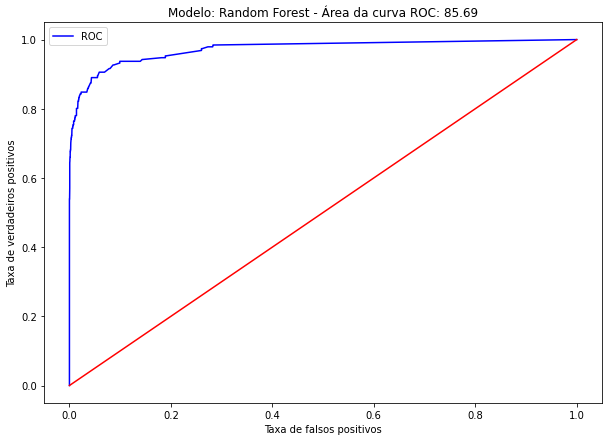

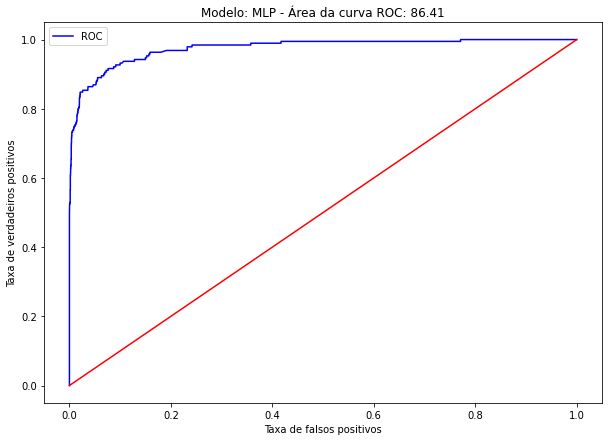

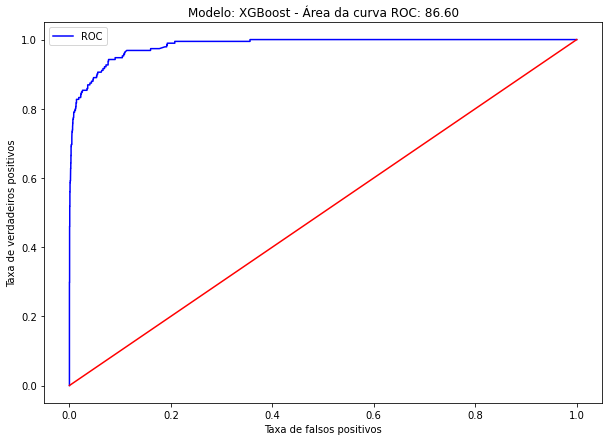


Hard Voting não retorna probabilidade.




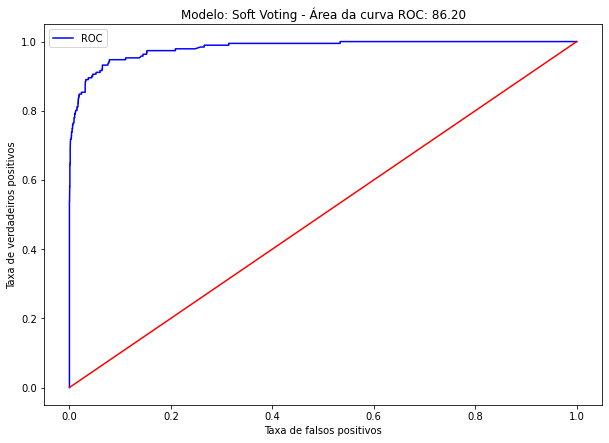

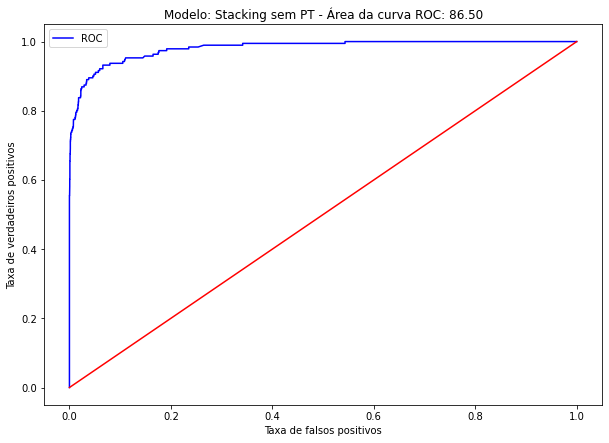

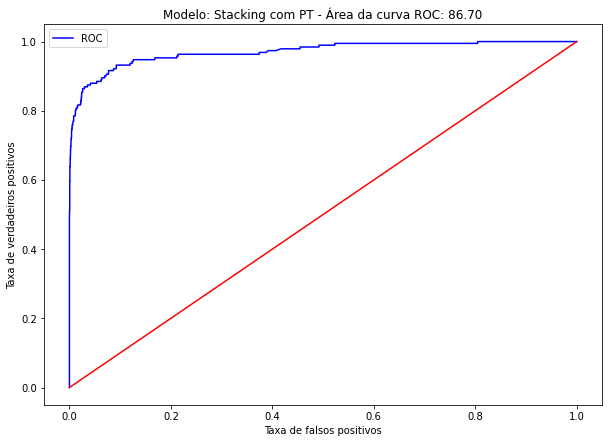

In [95]:
for modelo in modelos_sem_nlp_final:
  try:
    y_pred_proba = modelos_sem_nlp_final[modelo].predict_proba(x_test_sem_nlp)
    y_pred = modelos_sem_nlp_final[modelo].predict(x_test_sem_nlp)
    fpr,tpr,_ = roc_curve(y_test,y_pred_proba[:,1])
    print('\n')
    plot_roc_curve(fpr,tpr,roc_auc_score(y_test,y_pred)*100,modelo)
  except:
    print("\n{} não retorna probabilidade.".format(modelo))

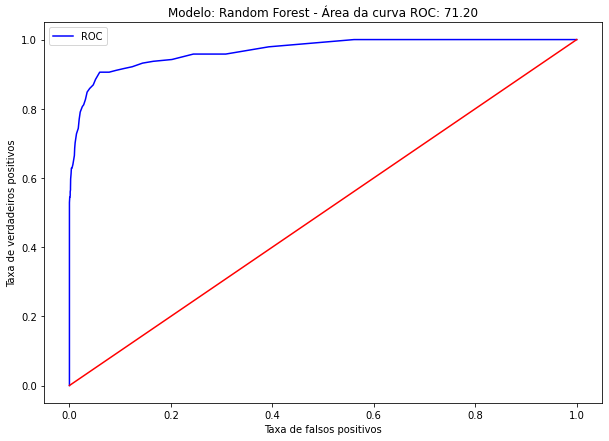

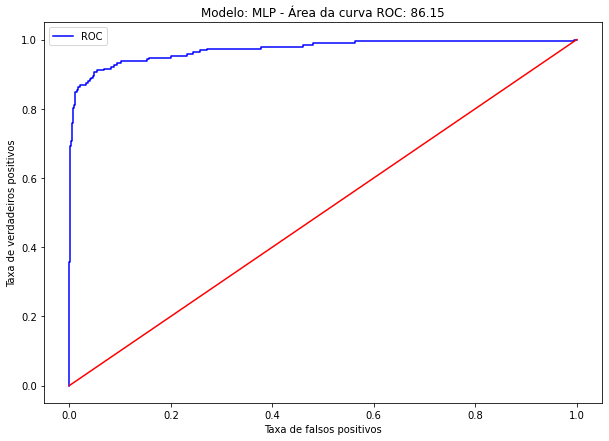

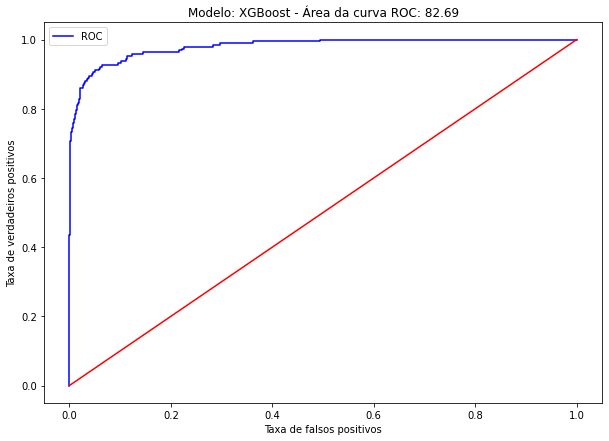


Hard Voting não retorna probabilidade.




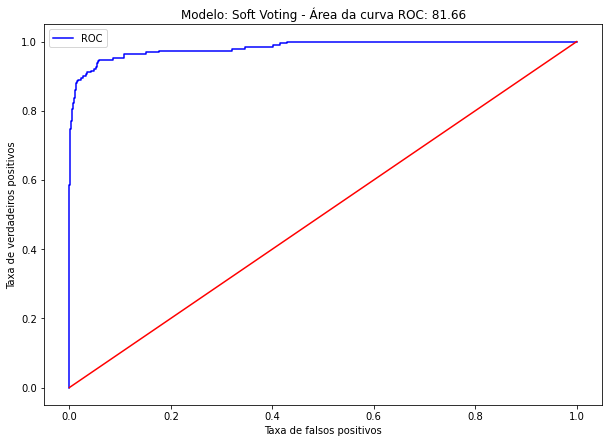

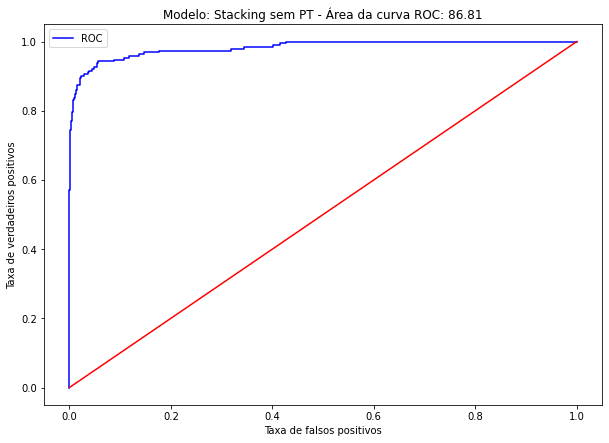

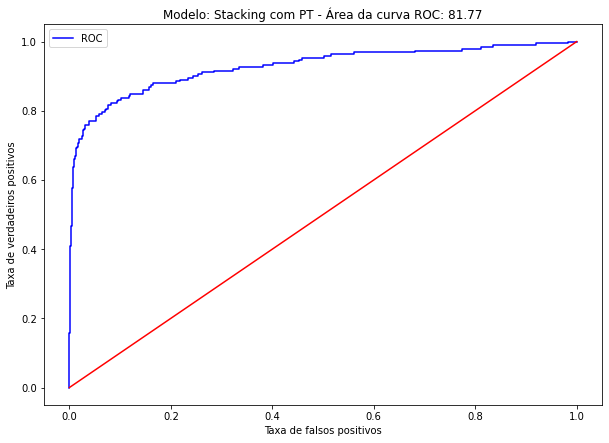

In [96]:
for modelo in modelos_com_nlp_final:
  try:
    y_pred_proba = modelos_com_nlp_final[modelo].predict_proba(x_test_com_nlp)
    y_pred = modelos_com_nlp_final[modelo].predict(x_test_com_nlp)
    fpr,tpr,_ = roc_curve(y_test,y_pred_proba[:,1])
    print('\n')
    plot_roc_curve(fpr,tpr,roc_auc_score(y_test,y_pred)*100,modelo)
  except:
    print("\n{} não retorna probabilidade.".format(modelo))

## 4.4 - Validação cruzada dos melhores modelos

Modelos escolhidos:
- **Stacking sem PT com NLP:**

Melhor acurácia na base de teste porém com overfit na base de treinamento e é um algoritmo de maior complexidade.

- **Stacking sem PT sem NLP:**

Segunda melhor acurácia na base de testes porém sem o total overfit da base de treinamento e é um algoritmo de menor complexidade por não usar as 300 colunas W2V.

- **Random Forest sem NLP:**

Acurácia menor que os outros (0.26 menor que o melhor) porém é um algoritmo muito menos complexo que os demais e exige um poder computacional muito menor.

Função para diminuir a dimensionalidade das variaveis

In [ ]:
def diminui_dim(data,categorias):
  col_pronta = []
  for linha in data:
    if linha in categorias:
      col_pronta.append(linha)
    else:
      col_pronta.append('Outros')
  return col_pronta

In [ ]:
x_cv = data.drop('fraudulent',axis=1).copy()
y_cv = data.fraudulent.copy()

Pre Processing que é possivel ser feito antes da separação de dados sem possuir data leakage

In [ ]:
x_cv = pp_nlp_has(x_cv)
x_cv = preencher_nulos(x_cv)
x_cv = pp_var_binarias(x_cv)
x_cv = junta_colunas_nlp(x_cv)
x_cv = criar_colunas_regex(x_cv)
x_cv = pp_paises(x_cv)

Modelos sem NLP

In [ ]:
x_cv_sem_nlp = x_cv.copy()
x_cv_sem_nlp.drop('texto',axis=1,inplace=True)

k = 10

cv = KFold(n_splits = k, shuffle = True)

models_cv_sem_nlp = {'Random Forest':rf_sem_nlp_melhor,
                     'Stacking sem NLP':ensemble_stacking_sem_nlp}

acc_cvs = {}

for nome in models_cv_sem_nlp:
  acc_cv = []
  for train_index, test_index in cv.split(x_cv_sem_nlp):
      # Separando train-test
      x_train_cv, x_test_cv = x_cv_sem_nlp.iloc[train_index], x_cv_sem_nlp.iloc[test_index]
      y_train_cv, y_test_cv = y_cv[train_index], y_cv[test_index]

      # PreProcessing
      ## Separando o salary_range pela mediana da base de teste
      data_salary_cv = x_train_cv[x_train_cv.salary_range!='Indefinido'].reset_index().salary_range
      medias_cv = [pega_media_salary(salary) for salary in data_salary_cv]
      mediana_salary_cv = statistics.median(medias_cv)
      x_train_cv['salary_range'] = x_train_cv.salary_range.apply(pp_salary_range)
      x_test_cv['salary_range'] = x_test_cv.salary_range.apply(pp_salary_range)

      ## Diminuindo dimensionalidade das variaveis categoricas
      min = int(len(x_train_cv)*0.01)
      for coluna in colunas_cat2:
        categorias_maior = list(x_train_cv[coluna].value_counts()[x_train_cv[coluna].value_counts() >= min].index)
        x_train_cv[coluna] = diminui_dim(x_train_cv[coluna],categorias_maior)
        x_test_cv[coluna] = diminui_dim(x_test_cv[coluna],categorias_maior)
        
      # OneHot das colunas categoricas
      x_train_cv = onehot_cat(x_train_cv)
      x_test_cv = onehot_cat(x_test_cv)
      
      # Criando coluna caso nao tenha sido criado no onehot de teste
      colunas_faltantes = [coluna for coluna in x_train_cv.columns if coluna not in x_test_cv.columns]
      for coluna in colunas_faltantes:
        x_test_cv[coluna] = 0

      # Train the model
      model = models_cv_sem_nlp[nome].fit(x_train_cv, y_train_cv)
      # Add a acurácia na lista
      acc_cv.append(round(accuracy_score(y_test_cv, model.predict(x_test_cv))*100,3))
  acc_cvs[nome] = acc_cv

Modelo com NLP

In [ ]:
x_cv_com_nlp = x_cv.copy()
x_cv_com_nlp = limpa_texto(x_cv_com_nlp)
docs = nlp.pipe(x_cv_com_nlp.texto, n_process=-1)
vetores_resultantes = [processo_completo(doc) for doc in docs]
data_vetores = pd.DataFrame(vetores_resultantes)
x_cv_com_nlp.drop('texto',axis=1,inplace=True)
x_cv_com_nlp = pd.concat([x_cv_com_nlp,data_vetores],axis=1)

In [ ]:
k = 10

cv = KFold(n_splits = k, shuffle = True)

acc_cv = []
for train_index, test_index in cv.split(x_cv_com_nlp):
  # Separando train-test
  x_train_cv, x_test_cv = x_cv_com_nlp.iloc[train_index], x_cv_com_nlp.iloc[test_index]
  y_train_cv, y_test_cv = y_cv[train_index], y_cv[test_index]

  # PreProcessing
  ## Separando o salary_range pela mediana da base de teste
  data_salary_cv = x_train_cv[x_train_cv.salary_range!='Indefinido'].reset_index().salary_range
  medias_cv = [pega_media_salary(salary) for salary in data_salary_cv]
  mediana_salary_cv = statistics.median(medias_cv)
  x_train_cv['salary_range'] = x_train_cv.salary_range.apply(pp_salary_range)
  x_test_cv['salary_range'] = x_test_cv.salary_range.apply(pp_salary_range)

  ## Diminuindo dimensionalidade das variaveis categoricas
  min = int(len(x_train_cv)*0.01)
  for coluna in colunas_cat2:
    categorias_maior = list(x_train_cv[coluna].value_counts()[x_train_cv[coluna].value_counts() >= min].index)
    x_train_cv[coluna] = diminui_dim(x_train_cv[coluna],categorias_maior)
    x_test_cv[coluna] = diminui_dim(x_test_cv[coluna],categorias_maior)
          
  # OneHot das colunas categoricas
  x_train_cv = onehot_cat(x_train_cv)
  x_test_cv = onehot_cat(x_test_cv)
        
  # Criando coluna caso nao tenha sido criado no onehot de teste
  colunas_faltantes = [coluna for coluna in x_train_cv.columns if coluna not in x_test_cv.columns]
  for coluna in colunas_faltantes:
    x_test_cv[coluna] = 0

  # Train the model
  model = ensemble_stacking_com_nlp.fit(x_train_cv, y_train_cv)
  # Add a acurácia na lista
  acc_cv.append(round(accuracy_score(y_test_cv, model.predict(x_test_cv))*100,3))
acc_cvs['Stacking com NLP'] = acc_cv

Avaliação

In [ ]:
pd.DataFrame(acc_cvs)

,Random Forest,Stacking sem NLP,Stacking com NLP
0,98.098,98.378,98.714
1,98.546,98.937,98.266
2,98.154,97.539,98.154
3,98.210,98.210,98.154
4,98.266,98.043,98.434
5,97.987,97.763,98.602
6,97.931,97.987,98.490
7,97.763,97.427,98.770
8,97.595,97.987,98.490
9,97.987,98.490,98.714


In [ ]:
pd.DataFrame(acc_cvs).describe()

,Random Forest,Stacking sem NLP,Stacking com NLP
count,10.000000,10.000000,10.000000
mean,98.053700,98.076100,98.478800
std,0.267239,0.452934,0.228314
min,97.595000,97.427000,98.154000
25%,97.945000,97.819000,98.308000
50%,98.042500,98.015000,98.490000
75%,98.196000,98.336000,98.686000
max,98.546000,98.937000,98.770000


## 4.5 - Escolha e salvamento do modelo

Apesar do Stacking com NLP ter resultados melhores, a diferença para este caso não é grande o bastante que compense a demanda computacional tão maior que os outros. Entre o random forest sem nlp e o stacking sem nlp, o random forest teve resultado melhor na validação cruzada e é menos complexo, portanto é o melhor modelo para este caso.

In [103]:
rf_sem_nlp_melhor

RandomForestClassifier(random_state=50)

In [104]:
filename = "models/random_forest.sav"
pickle.dump(rf_sem_nlp_melhor, open(filename, "wb"))